**Autores**:

1. Javier Quesada Pajares
2. Jorge del Castillo Gómez

# Segundo Notebook. **Red Siamesa** con correspondencia [humano, maquina] y sin redundancia entre train, val y test set.
El modelo baseline presenta un desbalanceo en el dataset porque hay 1000 frases humanas y 14000 máquinas. Aunque la precisión sea alta, no es capaz de diferenciar humano - maquina, aunque clasifique correctamente las frases humanas.

Para solucionar este problema de desbalanceo en las muestras, se experimenta con una primera arquitectura llamada **BertConcatenateClassifier**, la cual trabaja con pares de frases [humano, máquina]. Cada par de frase se etiqueta con '0' si la frase humana es la primera del par, '1' si es la segunda. El objetivo es entrenar un modelo clasificador que se encargue de detectar la frase humana. Se plantea una arquitectura de red neuronal **Siamesa**.

<br>

<h3><strong>Arquitectura Siamesa</strong></h3>

>Es una red característica para la tarea de clasificación por pares. Dada una entrada de dos textos, ambos se procesan de manera independiente, obteniendo dos representaciones de embeddings. Mediante una operación de concatenación, se combina ambos embeddings y se pasa a una cabeza clasificadora. La salida de la cabeza clasificadora es el logit. En nuestro caso, el logit representa la evidencia de la detección de la frase humana. La función de pérdida (loss) aplica la función de activación sigmoid para obtener la probabilidad binaria.

<br>
Los modelos de este notebook se ejecutan con un dataset que tiene las siguientes dos caracteristicas:

1. Se crean pares de frases "humano" y "maquina" manteniendo la correspondencia. Por ejemplo, la frase humana en el indice "7" se emparejará con cada frase máquina en el índice "7".

2. Se elimina la redundancia de pares de frases entre los conjuntos de entrenamiento, validacion y prueba.

<br>

<h3><strong>Modelos</strong></h3>

Los modelos se ejecutan con:
- Max_length = 128
- Epochs: 2. En dos EPOCHS, los modelos convergen con una *loss* próxima a 0.
- Train_batch_size: 10
- Val_batch_size: 5
- Learning_rate: 1e-4
- Optimizer: Adam

Se crean 3 conjuntos de datos: entrenamiento, validación y prueba.


>```<val set = 0.1 * train set>``` <br>
>```<test set = 0.2 * train set>```


---

**[M1]**: Completed Fine-Tuning with Bert

Este primer modelo incluye una capa clasificadora que procesa una concatenación de los embeddigs del par de inputs. Se realiza un Fine-Tuning de todas las capas del modelo preentrenado *berta-uncased*.

---

**[M2]**: Fine-Tuning last-3-layers with Bert

Se parte del modelo [M1], incluyendo un Fine-Tuning de las últimas 3 capas del modelo preentrenado *berta-uncased*.

---

**[M3]**: Similarity test with Bert. Fine-Tuning last-3-layers

Se parte del modelo [M2], incluyendo un Fine-Tuning de las últimas 3 capas del modelo preentrenado *berta-uncased*. La novedad de este modelo es la adicción de una operación de resta (o diferenciación) entre las representaciones de salida del modelo Bert para las dos frases humano - máquina.

---

**[M4]**: Fine-Tuning last-3-layers with Deberta

Se parte del modelo [M2]; se realiza un Fine-Tuning del nuevo modelo seleccionado llamado Deberta-base.

---

**[M5]**: Similarity test with Deberta. Fine-Tuning last-3-layers

Se parte del modelo [M4]; se realiza un Fine-Tuning del Deberta-base. Este modelo incluye la operación de resta (o diferenciación, al igual que se implementó en el modelo [M3] para Bert) entre las representaciones de salida del modelo Deberta para las dos frases humano - máquina.

<br>

<h3><strong>Evaluación</strong></h3>

La siguiente tabla muestra la comparación de las métricas de los 5 modelos propuestos.

<b>Conclusión</b>: los modelos (<b>M3</b>, <b>M5</b>) que incorporan una operación de diferenciación entre las representaciones de los embeddings de salida del Bert y Deberta son los que devuelven mejores resultados.

> *Los modelos en <font color="red"><b>rojo</b></font> usan Bert.*

> *Los modelos en <font color="blue"><b>azul</b></font> usan Deberta.*


| Modelo            | Val Loss (Epoch 1) | Val Loss (Epoch 2) | Accuracy  | ROC_AUC  | F1        | F0.5      | BRIER     | C@1       |
|-------------------|--------------------|--------------------|-----------|----------|-----------|-----------|-----------|-----------|
| <font color="red"><b>M1</b></font> | 0.1011             | 0.0562             | 0.9841    | 0.9976   | 0.9845    | 0.9839    | 0.9841    | 0.9841    |
| <font color="red"><b>M2</b></font> | 0.0675             | 0.1038             | 0.9767    | 0.9976   | 0.9771    | 0.9687    | 0.9785    | 0.9767    |
| <font color="red"><b>M3</b></font> | 0.0302             | 0.0775             | <b>0.9876</b>    | 0.9992   | <b>0.9874</b>    | 0.9838    | 0.9887    | <b>0.9876</b>    |
| <font color="blue"><b>M4</b></font> | 0.0177             | <b>0.0008</b>             | 0.9866    | 0.9996   | 0.9868    | 0.9807    | 0.9905    | 0.9866    |
| <font color="blue"><b>M5</b></font> | <b>0.0018</b>             | 0.0037             | 0.9852    | <b>0.9997</b>   | 0.9853    | <b>0.9911</b>    | <b>0.9910</b>    | 0.9852    |





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
!pip install -q transformers

In [ ]:
import pandas as pd
import json
import os
import random


import numpy as np

from sklearn import metrics
from sklearn.model_selection  import train_test_split

import transformers

from transformers import AutoModel, AutoTokenizer
from transformers import DebertaV2Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Data Preprocessing

In [ ]:
# Lectura del dataset de frases humanas
#df_humans = pd.read_json('/content/drive/MyDrive/Universidad/Master/Primer semestre/Bloque_2/NLP/Proyecto/human.jsonl', lines=True)
df_humans = pd.read_json('/content/drive/MyDrive/NLP/human.jsonl', lines=True)

In [ ]:
df_humans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1087 non-null   object
 1   text    1087 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [ ]:
df_humans.head(5)

,id,text
0,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...
1,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...
2,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...
3,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak..."
4,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...


In [ ]:
# Lectura del dataset de frases de máquinas

#path = '/content/drive/MyDrive/Universidad/Master/Primer semestre/Bloque_2/NLP/Proyecto/machines'
path = '/content/drive/MyDrive/NLP/machines'
df_machines_list = []
df_machines = None

for idx, file in enumerate(os.listdir(path)):
    print(f"Archivo {idx}")
    file_path = os.path.join(path, file)
    df_machine = pd.read_json(file_path, lines=True)
    print(f"Longitud del archivo {file}: {len(df_machine)}")
    df_machines_list.append(df_machine)

    df_machines = pd.concat([df_machine, df_machines])


print(f"Longitud de lista de df de maquinas: {len(df_machines_list)}")

Archivo 0
Longitud del archivo meta-llama-llama-2-7b-chat-hf.jsonl: 1087
Archivo 1
Longitud del archivo gemini-pro.jsonl: 1087
Archivo 2
Longitud del archivo gpt-4-turbo-preview.jsonl: 1087
Archivo 3
Longitud del archivo meta-llama-llama-2-70b-chat-hf.jsonl: 1087
Archivo 4
Longitud del archivo gpt-3.5-turbo-0125.jsonl: 1087
Archivo 5
Longitud del archivo alpaca-7b.jsonl: 1087
Archivo 6
Longitud del archivo qwen-qwen1.5-72b-chat-8bit.jsonl: 1087
Archivo 7
Longitud del archivo mistralai-mistral-7b-instruct-v0.2.jsonl: 1087
Archivo 8
Longitud del archivo chavinlo-alpaca-13b.jsonl: 1087
Archivo 9
Longitud del archivo bigscience-bloomz-7b1.jsonl: 1087
Archivo 10
Longitud del archivo mistralai-mixtral-8x7b-instruct-v0.1.jsonl: 1087
Archivo 11
Longitud del archivo vicgalle-gpt2-open-instruct-v1.jsonl: 1087
Archivo 12
Longitud del archivo text-bison-002.jsonl: 1087
Longitud de lista de df de maquinas: 13


### Generate pairs
Se crean los conjuntos **training**, **val** y **test set**, dividiendo las frases humanas en 3 conjuntos, de tal manera que no habrá redundancia de pares de frases en los conjuntos.

> La función generate_pairs() genera pares de combinaciones entre las frases humano y sus correspondientes 13 máquinas sin redundancia. Las frases que aparecen en un conjunto (por ejemplo, en train) no aparecen en el otro conjunto (por ejemplo, en test)

In [ ]:
def generate_pairs(df_humans, df_machines_list, max_pairs=13):
    pairs = []
    textos_humanos = list(df_humans['text'])

    for idx_humano, humano in enumerate(textos_humanos):
        # Para cada frase humana combinamos con las frases de las máquinas correspondientes
        for idx_machine in range(min(len(df_machines_list), max_pairs)):
            # se recupera la frase de máquina correspondiente al índice original de la humana
            maquina = df_machines_list[idx_machine].loc[df_humans.index[idx_humano], 'text']

            pair_1 = {'text_1': humano, 'text_2': maquina, 'label': 0}  # humana, máquina
            pair_2 = {'text_1': maquina, 'text_2': humano, 'label': 1}  # máquina, humana

            # aleatoriamente se selecciona uno
            selected_pair = random.choice([pair_1, pair_2])
            pairs.append(selected_pair)


    return pd.DataFrame(pairs)

> El siguiente código se ejecuta para probar que la función generate_pairs() funciona correctamente, analizando las coincidencias entre los conjuntos de entrenamiento, test y de validación.

In [ ]:
df_humans_train_1, df_humans_test_1 = train_test_split(df_humans, test_size=0.2, random_state=42)
df_humans_train_1, df_humans_val_1 = train_test_split(df_humans_train_1, test_size=0.1, random_state=42)

# Se filtran los dataFrames de máquinas según los índices de los subconjuntos de humanos
df_machines_list_train_1 = [df_machine.loc[df_humans_train_1.index] for df_machine in df_machines_list]
df_machines_list_val_1 = [df_machine.loc[df_humans_val_1.index] for df_machine in df_machines_list]
df_machines_list_test_1 = [df_machine.loc[df_humans_test_1.index] for df_machine in df_machines_list]

train_df_1 = generate_pairs(df_humans_train_1, df_machines_list_train_1)
val_df_1 = generate_pairs(df_humans_val_1, df_machines_list_val_1)
test_df_1 = generate_pairs(df_humans_test_1, df_machines_list_test_1)

In [ ]:
train_texts = set(train_df_1['text_1']).union(set(train_df_1['text_2']))
val_texts = set(val_df_1['text_1']).union(set(val_df_1['text_2']))
test_texts = set(test_df_1['text_1']).union(set(test_df_1['text_2']))

# Intersecciones para detectar redundancias
train_val_overlap = train_texts.intersection(val_texts)
train_test_overlap = train_texts.intersection(test_texts)
val_test_overlap = val_texts.intersection(test_texts)

# Resultados de redundancia
print(f"Frases redundantes entre train y val: {len(train_val_overlap)}")
print(f"Frases redundantes entre train y test: {len(train_test_overlap)}")
print(f"Frases redundantes entre val y test: {len(val_test_overlap)}")

Frases redundantes entre train y val: 1
Frases redundantes entre train y test: 1
Frases redundantes entre val y test: 1


### CustomDatasets

In [ ]:
MAX_LEN = 128 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 10 # @param {type:"integer"}
VALID_BATCH_SIZE = 5 # @param {type:"integer"}
EPOCHS = 2 # @param {type:"integer"}
LEARNING_RATE = 1e-4 # @param {type:"number"}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizerDeberta = AutoTokenizer.from_pretrained("microsoft/deberta-base")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

> El CustomDataset_simple devuelve las features [text_1, text_2, label] con las que se va a alimentar el modelo.

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset_simple(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.comment_text_1 = self.data['text_1']
        self.comment_text_2 = self.data['text_2']
        self.target = self.data['label']

    def __len__(self):
        return len(self.comment_text_1)

    def __getitem__(self, index):

        comment_text_1 = str(self.comment_text_1[index])
        comment_text_2 = str(self.comment_text_2[index])
        target_value = self.target.iloc[index] if isinstance(self.target, pd.Series) else self.target[index]

        return {
            'comment_text_1': comment_text_1,
            'comment_text_2': comment_text_2,
            'label': target_value
        }

> El CustomDataset_completo se encarga también de tokenizar y devolver los inputs_ids, mask y inputs_type_ids.

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset_completo(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=MAX_LEN):
        """
        Constructor de la clase, que toma un dataframe con columnas 'text_1', 'text_2' y 'label'.
        Además, recibe un tokenizer y un tamaño máximo de secuencia (max_len).
        """
        self.data = dataframe
        self.comment_text_1 = self.data['text_1']
        self.comment_text_2 = self.data['text_2']
        self.target = self.data['label']
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """
        Devuelve el tamaño del dataset (número de muestras).
        """
        return len(self.comment_text_1)

    def __getitem__(self, index):
        """
        Devuelve un diccionario con los textos tokenizados y la etiqueta para el índice especificado.
        """
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_2 = str(self.comment_text_2[index])
        target_value = self.target.iloc[index] if isinstance(self.target, pd.Series) else self.target[index]

        # Tokenizar los textos
        encodings_1 = self.tokenizer.encode_plus(
            comment_text_1,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        encodings_2 = self.tokenizer.encode_plus(
            comment_text_2,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        # se convierten los targets a un tensor
        target_tensor = torch.tensor(target_value, dtype=torch.float)

        return {
            'ids_0': encodings_1['input_ids'].squeeze(0),
            'mask_0': encodings_1['attention_mask'].squeeze(0),
            'token_type_ids_0': encodings_1['token_type_ids'].squeeze(0),
            'ids_1': encodings_2['input_ids'].squeeze(0),
            'mask_1': encodings_2['attention_mask'].squeeze(0),
            'token_type_ids_1': encodings_2['token_type_ids'].squeeze(0),
            'target': target_tensor
        }

### DataCollator

In [ ]:
from psutil import cpu_count
print("Número de núcleos de CPU:", cpu_count())

Número de núcleos de CPU: 2


> Al hacer uso de la clase CustomDatasetCompleto, el cual tokeniza y genera los datos necesarios con encode_plus, **no se hace uso de la clase DataCollator**. La clase DataCollator implementada tokeniza y genera las máscaras, token_type_ids_1 y los tokens ids de batch en batch.

In [ ]:
class DataCollator:
    def __init__(self, tokenizer, max_len=MAX_LEN):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, input_batch):

        batch_df = pd.DataFrame(input_batch)


        encodings_1 = self.tokenizer.encode_plus(
            batch_df['comment_text_1'].tolist(),
            truncation=True,
            padding='max_length',
            max_length=self.max_len
        )


        encodings_2 = self.tokenizer.encode_plus(
            batch_df['comment_text_2'].tolist(),
            truncation=True,
            padding='max_length',
            max_length=self.max_len
        )

        ids_0 = torch.tensor(encodings_1['input_ids'], dtype=torch.long)
        mask_0 = torch.tensor(encodings_1['attention_mask'], dtype=torch.long)
        token_type_ids_0 = torch.tensor(encodings_1['token_type_ids'], dtype=torch.long)

        ids_1 = torch.tensor(encodings_2['input_ids'], dtype=torch.long)
        mask_1 = torch.tensor(encodings_2['attention_mask'], dtype=torch.long)
        token_type_ids_1 = torch.tensor(encodings_2['token_type_ids'], dtype=torch.long)


        targets = torch.tensor(batch_df['label'].values, dtype=torch.float)

        batch = {
            'ids_0': ids_0,
            'mask_0': mask_0,
            'token_type_ids_0': token_type_ids_0,
            'ids_1': ids_1,
            'mask_1': mask_1,
            'token_type_ids_1': token_type_ids_1,
            'target': targets
        }

        return batch


### Preparing Data

> Se hace uso de las clases implementadas anteriormente:

1. Se dividen las frases humanas en los conjuntos de entrenamiento, test y validación con la función train_test_split()
2. Se obtienen las frases máquinas correspondientes a las humanas de cada conjunto.
3. Se generan los pares de frases humano - máquina con la función generate_pairs()
4. Se hace uso de CustomDataset_completo() para obtener los datos preprocesados, listos para usarlos en el modelo.
5. Se cargan los conjuntos de datos en el DataLoader, indicando el tamaño de batch.

In [ ]:
df_humans_train, df_humans_test = train_test_split(df_humans, test_size=0.2, random_state=42)
df_humans_train, df_humans_val = train_test_split(df_humans_train, test_size=0.1, random_state=42)

# Se filtran los dataFrames de máquinas según los índices de los subconjuntos de humanos
df_machines_list_train = [df_machine.loc[df_humans_train.index] for df_machine in df_machines_list]
df_machines_list_val = [df_machine.loc[df_humans_val.index] for df_machine in df_machines_list]
df_machines_list_test = [df_machine.loc[df_humans_test.index] for df_machine in df_machines_list]

train_df = generate_pairs(df_humans_train, df_machines_list_train)
val_df = generate_pairs(df_humans_val, df_machines_list_val)
test_df = generate_pairs(df_humans_test, df_machines_list_test)

print(f"Training samples: {train_df.shape}")
print(f"Validation samples: {val_df.shape}")
print(f"Testing samples: {test_df.shape}")

X_train = train_df.reset_index(drop=True)
X_val = val_df.reset_index(drop=True)
X_test = test_df.reset_index(drop=True)

### CustomDataset completo
train_dataset = CustomDataset_completo(X_train, tokenizer)
val_dataset = CustomDataset_completo(X_val, tokenizer)
test_dataset = CustomDataset_completo(X_test, tokenizer)

train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 2}
val_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}

print("TRAIN Dataset: {}".format(X_train.shape))
print("VAL Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **val_params)
testing_loader = DataLoader(test_dataset, **test_params)

Training samples: (10166, 3)
Validation samples: (1131, 3)
Testing samples: (2834, 3)
TRAIN Dataset: (10166, 3)
VAL Dataset: (1131, 3)
TEST Dataset: (2834, 3)


## Models

### ▶ M1 Completed Fine-Tuning with Bert

Este modelo sigue la estructura del baseline, con las siguientes modificaciones:

- El modelo debe predecir cuál de las dos frases es humana
- Uso de bert-base-uncased como modelo base
- Se realiza un Fine-Tuning de todas las capas del modelo bert-base-uncased
- Se añade una cabeza clasificadora

#### Model

In [ ]:
class BertConcatenateClassifier(torch.nn.Module):
    def __init__(self):
        super(BertConcatenateClassifier, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 2)
        self.classifier = torch.nn.Linear(self.hidden_embd * 2, self.output_layer)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
        # Se obtienen embeddings para ambas oraciones
        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        # Concatenan los embeddings
        combined_output = torch.cat((output_0, output_1), dim=1)

        # Dropout y luego la capa lineal para hacer la predicción
        combined_output = self.dropout(combined_output)
        output = self.classifier(combined_output)

        return output

In [ ]:
model = BertConcatenateClassifier()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertConcatenateClassifier(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

#### Training process

- La **función pérdida** empleada es la *BCEWithLogitsLoss*; esta función aplica una binary cross entropy sobre el resultado de aplicar la función de activación sigmoid a los logits.

- El **optimizador** usado es *Adam*.

La novedad del método train es la inclusión de una **fase de validación** al final de cada epoch. La validación se implementa en la función evaluate(); se usa el modelo con los gradiantes desactivados para inferir las clases del conjunto de validación y se calcula la loss promedio de los datos de validación en cada epoch.

- Si la loss de una epoch mejora la mejor loss de las epochs anteriores, entonces se exporta el modelo. De esta forma, nos quedamos con la mejor configuración de pesos del modelo.

In [ ]:
# Se define la funcion pérdida
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Optimizador
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.optim as optim
import time

# Método de entrenamiento
def train(model, training_loader, validation_loader, EPOCHS = 2):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):

      print(f"epoch[{epoch}]")

      model.train()

      start_epoch_time = time.time()  # Hora de inicio de la época
      batch_time_accum = 0

      for i, data in enumerate(training_loader, 0):

          # Sincroniza antes de comenzar el batch
          if torch.cuda.is_available():
                torch.cuda.synchronize()

          start_batch_time = time.time()  # Hora de inicio del batch

          ids_0 = data['ids_0'].to(device, dtype=torch.long)
          mask_0 = data['mask_0'].to(device, dtype=torch.long)
          token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

          ids_1 = data['ids_1'].to(device, dtype=torch.long)
          mask_1 = data['mask_1'].to(device, dtype=torch.long)
          token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

          targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)

          optimizer.zero_grad()

          outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

          loss = loss_fn(outputs, targets)

          loss.backward()

          optimizer.step()

          if torch.cuda.is_available():
                torch.cuda.synchronize()

          end_batch_time = time.time()
          batch_duration = end_batch_time - start_batch_time
          batch_time_accum += batch_duration


          if i % 100 == 0:  # Cada 100 batches
              print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}, 'f'Time for last 100 batches: {batch_time_accum:.2f} sec')
              batch_time_accum = 0


      ### Validacion
      val_loss = evaluate(model, validation_loader)

      print(f'Validation Loss after Epoch {epoch}: {val_loss:.4f}')

      # Se guarda el modelo si la pérdida de validación ha mejorado
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f'Saving model with improved validation loss: {val_loss:.4f}')
          torch.save(model.state_dict(), '/content/bertConcatenateClassifier_corresp_noRepe.pth')

      end_epoch_time = time.time()
      epoch_duration = end_epoch_time - start_epoch_time
      print(f'Epoch {epoch} completed in {epoch_duration:.2f} sec')


def evaluate(model, validation_loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    start_eval_time = time.time()  # Hora de inicio de la evaluación

    with torch.no_grad():
        for data in validation_loader:

            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)


            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)


            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * len(targets)  # la pérdida ponderada por el tamaño del batch
            total_samples += len(targets)

    average_loss = total_loss / total_samples  # Promedio de la pérdida


    end_eval_time = time.time()
    eval_duration = end_eval_time - start_eval_time
    print(f'Evaluation completed in {eval_duration:.2f} sec')

    return average_loss

In [ ]:
train(model, training_loader, val_loader, 2)

epoch[0]
Epoch: 0, Batch: 0, Loss: 0.6975, Time for last 100 batches: 2.33 sec
Epoch: 0, Batch: 100, Loss: 0.0019, Time for last 100 batches: 39.40 sec
Epoch: 0, Batch: 200, Loss: 0.0652, Time for last 100 batches: 40.89 sec
Epoch: 0, Batch: 300, Loss: 0.0005, Time for last 100 batches: 42.06 sec
Epoch: 0, Batch: 400, Loss: 0.0065, Time for last 100 batches: 42.12 sec
Epoch: 0, Batch: 500, Loss: 0.0400, Time for last 100 batches: 41.99 sec
Epoch: 0, Batch: 600, Loss: 0.0685, Time for last 100 batches: 41.99 sec
Epoch: 0, Batch: 700, Loss: 0.0001, Time for last 100 batches: 41.88 sec
Epoch: 0, Batch: 800, Loss: 0.0004, Time for last 100 batches: 41.92 sec
Epoch: 0, Batch: 900, Loss: 0.0015, Time for last 100 batches: 42.01 sec
Epoch: 0, Batch: 1000, Loss: 0.0030, Time for last 100 batches: 41.99 sec
Evaluation completed in 31.70 sec
Validation Loss after Epoch 0: 0.1011
Saving model with improved validation loss: 0.1011
Epoch 0 completed in 480.58 sec
epoch[1]
Epoch: 1, Batch: 0, Loss: 

#### Validating the Model

<center> <b>test set = 0.20 * dataset </b></center>

**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("/content/bertConcatenateClassifier_corresp_noRepe.pth"))

<ipython-input-21-88d694618344>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/bertConcatenateClassifier_corresp_noRepe.pth"))


<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs2)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"C@1 Score = {c1_score}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.984121383203952
ROC_AUC Score = 0.9975785682107218
F1 Score = 0.9845201238390093
F0.5 Score = 0.9839108910891089
C@1 Score = 0.984121383203952
Brier Score = 0.984121383203952


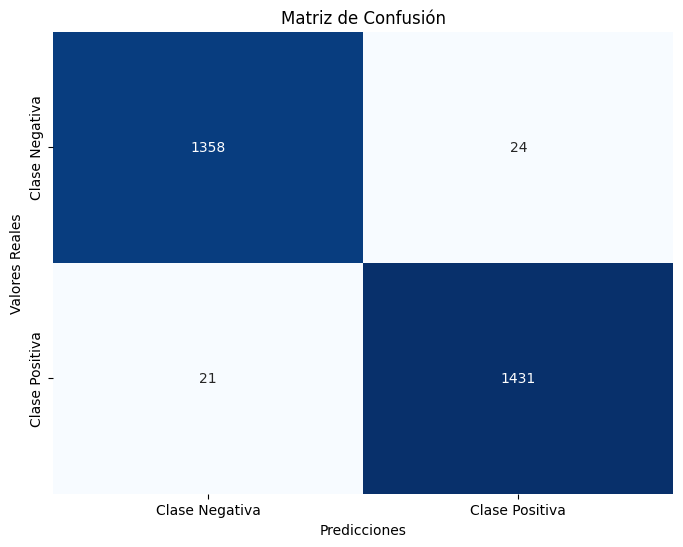

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

### ▶ M2 Fine-Tuning last-3-layers with Bert

Este modelo es similar al modelo [M1] excepto en el Fine-Tuning: se congelan la mayoría de capas de Bert.

- Se realiza un Fine-Tuning excepto de las ultimas 3 capas de BERT

#### Model

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

N = 3  # Número de capas finales que NO queremos congelar
for name, param in model.named_parameters():
    if "encoder.layer" in name:               # Si el parámetro es parte del encoder
        layer_num = int(name.split(".")[2])   # Extrae el número de la capa
        if layer_num < (12 - N):              # Congela todas las capas excepto las últimas N
            param.requires_grad = False
    elif "classifier" in name:                # Deja sin congelar la capa de clasificación
        param.requires_grad = True

for name, param in model.named_parameters():
  print(f"Capa: {name} | Congelada: {not param.requires_grad}")

Capa: embeddings.word_embeddings.weight | Congelada: False
Capa: embeddings.position_embeddings.weight | Congelada: False
Capa: embeddings.token_type_embeddings.weight | Congelada: False
Capa: embeddings.LayerNorm.weight | Congelada: False
Capa: embeddings.LayerNorm.bias | Congelada: False
Capa: encoder.layer.0.attention.self.query.weight | Congelada: True
Capa: encoder.layer.0.attention.self.query.bias | Congelada: True
Capa: encoder.layer.0.attention.self.key.weight | Congelada: True
Capa: encoder.layer.0.attention.self.key.bias | Congelada: True
Capa: encoder.layer.0.attention.self.value.weight | Congelada: True
Capa: encoder.layer.0.attention.self.value.bias | Congelada: True
Capa: encoder.layer.0.attention.output.dense.weight | Congelada: True
Capa: encoder.layer.0.attention.output.dense.bias | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.weight | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.bias | Congelada: True
Capa: encoder.layer.0.inter

In [ ]:
class BertConcatenateClassifier_freezing(torch.nn.Module):
    def __init__(self, model):
        super(BertConcatenateClassifier_freezing, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = model
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 2)
        self.classifier = torch.nn.Linear(self.hidden_embd * 2, self.output_layer)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):

        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        combined_output = torch.cat((output_0, output_1), dim=1)

        combined_output = self.dropout(combined_output)
        output = self.classifier(combined_output)

        return output

In [ ]:
model = BertConcatenateClassifier_freezing(model)
model.to(device)

BertConcatenateClassifier_freezing(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

#### Training process

In [ ]:
# Se define la funcion pérdida
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.optim as optim
import time

# Método de entrenamiento
def train(model, training_loader, validation_loader, EPOCHS = 2):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):

      print(f"epoch[{epoch}]")

      model.train()

      start_epoch_time = time.time()  # Hora de inicio de la época
      batch_time_accum = 0

      for i, data in enumerate(training_loader, 0):

          # Sincroniza antes de comenzar el batch
          if torch.cuda.is_available():
                torch.cuda.synchronize()

          start_batch_time = time.time()  # Hora de inicio del batch

          ids_0 = data['ids_0'].to(device, dtype=torch.long)
          mask_0 = data['mask_0'].to(device, dtype=torch.long)
          token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

          ids_1 = data['ids_1'].to(device, dtype=torch.long)
          mask_1 = data['mask_1'].to(device, dtype=torch.long)
          token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

          targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)

          optimizer.zero_grad()

          outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

          loss = loss_fn(outputs, targets)

          loss.backward()

          optimizer.step()

          if torch.cuda.is_available():
                torch.cuda.synchronize()

          end_batch_time = time.time()
          batch_duration = end_batch_time - start_batch_time
          batch_time_accum += batch_duration


          if i % 100 == 0:  # Cada 100 batches
              print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}, 'f'Time for last 100 batches: {batch_time_accum:.2f} sec')
              batch_time_accum = 0

      ### Validacion
      val_loss = evaluate(model, validation_loader)

      print(f'Validation Loss after Epoch {epoch}: {val_loss:.4f}')

      # Se guarda el modelo si la pérdida de validación ha mejorado
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f'Saving model with improved validation loss: {val_loss:.4f}')
          torch.save(model.state_dict(), '/content/bertConcatenateClassifier_Freezing_corresp_noRepe.pth')

      end_epoch_time = time.time()
      epoch_duration = end_epoch_time - start_epoch_time
      print(f'Epoch {epoch} completed in {epoch_duration:.2f} sec')


def evaluate(model, validation_loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    start_eval_time = time.time()  # Hora de inicio de la evaluación

    with torch.no_grad():
        for data in validation_loader:

            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)


            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)


            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * len(targets)  # la pérdida ponderada por el tamaño del batch
            total_samples += len(targets)

    average_loss = total_loss / total_samples  # Promedio de la pérdida


    end_eval_time = time.time()
    eval_duration = end_eval_time - start_eval_time
    print(f'Evaluation completed in {eval_duration:.2f} sec')

    return average_loss

In [ ]:
train(model, training_loader, val_loader, 2)

epoch[0]
Epoch: 0, Batch: 0, Loss: 0.9091, Time for last 100 batches: 0.37 sec
Epoch: 0, Batch: 100, Loss: 0.0033, Time for last 100 batches: 31.20 sec
Epoch: 0, Batch: 200, Loss: 0.0153, Time for last 100 batches: 31.90 sec
Epoch: 0, Batch: 300, Loss: 0.0195, Time for last 100 batches: 31.46 sec
Epoch: 0, Batch: 400, Loss: 0.0050, Time for last 100 batches: 31.54 sec
Epoch: 0, Batch: 500, Loss: 0.3132, Time for last 100 batches: 31.43 sec
Epoch: 0, Batch: 600, Loss: 0.0033, Time for last 100 batches: 31.28 sec
Epoch: 0, Batch: 700, Loss: 0.0002, Time for last 100 batches: 31.51 sec
Epoch: 0, Batch: 800, Loss: 0.0004, Time for last 100 batches: 31.49 sec
Epoch: 0, Batch: 900, Loss: 0.0033, Time for last 100 batches: 31.39 sec
Epoch: 0, Batch: 1000, Loss: 0.0027, Time for last 100 batches: 31.46 sec
Evaluation completed in 30.78 sec
Validation Loss after Epoch 0: 0.0675
Saving model with improved validation loss: 0.0675
Epoch 0 completed in 393.45 sec
epoch[1]
Epoch: 1, Batch: 0, Loss: 

<a id='section06'></a>
#### Validating the Model

**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("/content/bertConcatenateClassifier_Freezing_corresp_noRepe.pth"))

<ipython-input-47-eae75f752fe2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/bertConcatenateClassifier_Freezing_corresp_noRepe

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
# Umbral
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"C@1 Score = {c1_score}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.976711362032463
ROC_AUC Score = 0.9976462549256323
F1 Score = 0.9771309771309772
F0.5 Score = 0.9686727122835945
C@1 Score = 0.976711362032463
Brier Score = 0.9785137268684463


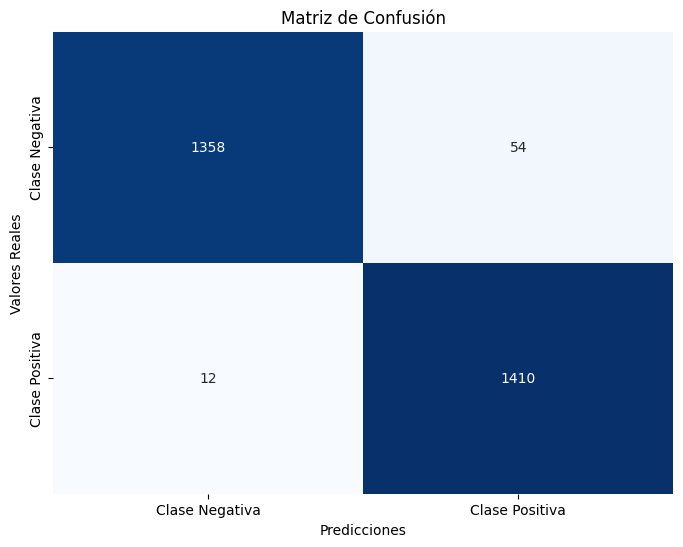

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

### ▶ M3 Similarity test with Bert. Fine-Tuning last-3-layers
Se congelan la mayoria de capas de Bert. Se parte del modelo [M2] pero con la adicción del calculo de similitud entre el embedding de la frase humana y la maquina.




#### Model

In [ ]:
model_bert = BertModel.from_pretrained('bert-base-uncased')

N = 3  # Número de capas finales que NO queremos congelar
for name, param in model_bert.named_parameters():
    if "encoder.layer" in name:  # Si el parámetro es parte del encoder
        layer_num = int(name.split(".")[2])  # Extrae el número de la capa
        if layer_num < (12 - N):  # Congela todas las capas excepto las últimas N
            param.requires_grad = False
    elif "classifier" in name:  # Deja sin congelar la capa de clasificación
        param.requires_grad = True

for name, param in model_bert.named_parameters():
  # Imprime el nombre de la capa y si está congelada (requires_grad=False)
  print(f"Capa: {name} | Congelada: {not param.requires_grad}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Capa: embeddings.word_embeddings.weight | Congelada: False
Capa: embeddings.position_embeddings.weight | Congelada: False
Capa: embeddings.token_type_embeddings.weight | Congelada: False
Capa: embeddings.LayerNorm.weight | Congelada: False
Capa: embeddings.LayerNorm.bias | Congelada: False
Capa: encoder.layer.0.attention.self.query.weight | Congelada: True
Capa: encoder.layer.0.attention.self.query.bias | Congelada: True
Capa: encoder.layer.0.attention.self.key.weight | Congelada: True
Capa: encoder.layer.0.attention.self.key.bias | Congelada: True
Capa: encoder.layer.0.attention.self.value.weight | Congelada: True
Capa: encoder.layer.0.attention.self.value.bias | Congelada: True
Capa: encoder.layer.0.attention.output.dense.weight | Congelada: True
Capa: encoder.layer.0.attention.output.dense.bias | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.weight | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.bias | Congelada: True
Capa: encoder.layer.0.inter

In [ ]:
class BertConcatenateSimilarityClassifier_freezing(torch.nn.Module):
    def __init__(self, model):
        super(BertConcatenateSimilarityClassifier_freezing, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = model
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 2)
        self.classifier = torch.nn.Linear(512, self.output_layer)

        self.compare_layer = torch.nn.Sequential(
            torch.nn.Linear(768 * 3, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.dropout_rate)
        )

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):


        # Obtener embeddings para ambas oraciones
        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        # Concatenar los embeddings
        combined_output = torch.cat([output_0, output_1, torch.abs(output_0 - output_1)], dim=1)
        x = self.compare_layer(combined_output)

        # luego la capa lineal para hacer la predicción
        output = self.classifier(x)

        return output

In [ ]:
model = BertConcatenateSimilarityClassifier_freezing(model_bert)
model.to(device)

BertConcatenateSimilarityClassifier_freezing(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

#### Training process

In [ ]:
# Se define la funcion pérdida
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.optim as optim
import time

# Método de entrenamiento
def train(model, training_loader, validation_loader, EPOCHS = 2):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):

      print(f"epoch[{epoch}]")

      model.train()

      start_epoch_time = time.time()  # Hora de inicio de la época
      batch_time_accum = 0

      for i, data in enumerate(training_loader, 0):

          # Sincroniza antes de comenzar el batch
          if torch.cuda.is_available():
                torch.cuda.synchronize()

          start_batch_time = time.time()  # Hora de inicio del batch

          ids_0 = data['ids_0'].to(device, dtype=torch.long)
          mask_0 = data['mask_0'].to(device, dtype=torch.long)
          token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

          ids_1 = data['ids_1'].to(device, dtype=torch.long)
          mask_1 = data['mask_1'].to(device, dtype=torch.long)
          token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

          targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)

          optimizer.zero_grad()

          outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

          loss = loss_fn(outputs, targets)

          loss.backward()

          optimizer.step()

          if torch.cuda.is_available():
                torch.cuda.synchronize()

          end_batch_time = time.time()
          batch_duration = end_batch_time - start_batch_time
          batch_time_accum += batch_duration


          if i % 100 == 0:  # Cada 100 batches
              print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}, 'f'Time for last 100 batches: {batch_time_accum:.2f} sec')
              batch_time_accum = 0

      ### Validacion
      val_loss = evaluate(model, validation_loader)

      print(f'Validation Loss after Epoch {epoch}: {val_loss:.4f}')

      # Se guarda el modelo si la pérdida de validación ha mejorado
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f'Saving model with improved validation loss: {val_loss:.4f}')
          torch.save(model.state_dict(), '/content/bertConcatenateClassifier_Freezing_corresp_withSimilarity.pth')

      end_epoch_time = time.time()
      epoch_duration = end_epoch_time - start_epoch_time
      print(f'Epoch {epoch} completed in {epoch_duration:.2f} sec')


def evaluate(model, validation_loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    start_eval_time = time.time()  # Hora de inicio de la evaluación

    with torch.no_grad():
        for data in validation_loader:

            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)


            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)


            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * len(targets)  # la pérdida ponderada por el tamaño del batch
            total_samples += len(targets)

    average_loss = total_loss / total_samples  # Promedio de la pérdida


    end_eval_time = time.time()
    eval_duration = end_eval_time - start_eval_time
    print(f'Evaluation completed in {eval_duration:.2f} sec')

    return average_loss

In [ ]:
train(model, training_loader, val_loader, 2)

epoch[0]
Epoch: 0, Batch: 0, Loss: 0.7039, Time for last 100 batches: 4.03 sec
Epoch: 0, Batch: 100, Loss: 0.0372, Time for last 100 batches: 31.10 sec
Epoch: 0, Batch: 200, Loss: 0.0028, Time for last 100 batches: 32.84 sec
Epoch: 0, Batch: 300, Loss: 0.3814, Time for last 100 batches: 32.85 sec
Epoch: 0, Batch: 400, Loss: 0.0003, Time for last 100 batches: 32.57 sec
Epoch: 0, Batch: 500, Loss: 0.0001, Time for last 100 batches: 32.87 sec
Epoch: 0, Batch: 600, Loss: 0.0735, Time for last 100 batches: 33.00 sec
Epoch: 0, Batch: 700, Loss: 0.0026, Time for last 100 batches: 32.59 sec
Epoch: 0, Batch: 800, Loss: 0.1763, Time for last 100 batches: 32.68 sec
Epoch: 0, Batch: 900, Loss: 0.0019, Time for last 100 batches: 32.98 sec
Epoch: 0, Batch: 1000, Loss: 0.0008, Time for last 100 batches: 32.74 sec
Evaluation completed in 40.34 sec
Validation Loss after Epoch 0: 0.0302
Saving model with improved validation loss: 0.0302
Epoch 0 completed in 457.51 sec
epoch[1]
Epoch: 1, Batch: 0, Loss: 

<a id='section06'></a>
#### Validating the Model


**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("/content/bertConcatenateClassifier_Freezing_corresp_withSimilarity.pth"))

<ipython-input-28-18c9b959c77a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/bertConcatenateClassifier_Freezing_corresp_withSi

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
# Umbral
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"C@1 Score = {c1_score}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.9876499647141849
ROC_AUC Score = 0.9991538485687931
F1 Score = 0.9874236435501258
F0.5 Score = 0.9838178433338106
C@1 Score = 0.9876499647141849
Brier Score = 0.988677352918297


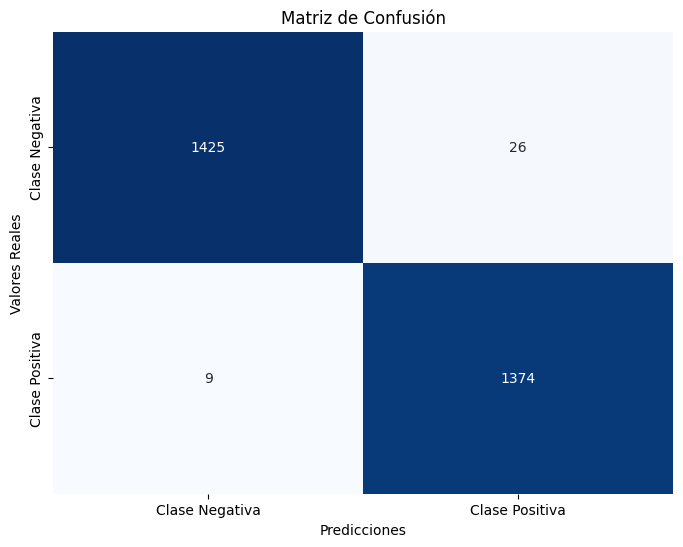

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

### 😯 Creation of a new test set

Las métricas de los modelos previamente entrenados son altamente positivas, lo que sugiere que el conjunto de datos de la tarea podría estar sesgado o diseñado para producir buenos resultados.

Para abordar esta posibilidad, se transforman las frases generadas por máquinas en el conjunto de prueba mediante un modelo de generación de texto (text2text-generation) con el objetivo de suavizar las diferencias estructurales entre las frases humanas y las generadas por máquina.

El propósito final es evaluar si el modelo puede responder adecuadamente, identificando correctamente las frases humanas.

In [ ]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def calcular_longitud_media(df, columna):
    longitudes = df[columna].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))  # Tokeniza y cuenta los tokens
    return longitudes.mean()

longitud_media_humana = calcular_longitud_media(df_humans, "text")
print(f"Longitud media de las frases humanas: {longitud_media_humana}")

df_machines = pd.concat(df_machines_list, ignore_index=True)

longitud_media_maquina = calcular_longitud_media(df_machines, "text")
print(f"Longitud media de las frases de las máquinas: {longitud_media_maquina}")

Token indices sequence length is longer than the specified maximum sequence length for this model (820 > 512). Running this sequence through the model will result in indexing errors


Longitud media de las frases humanas: 636.526218951242
Longitud media de las frases de las máquinas: 530.0717571297148


#### Generation Process

In [ ]:
from transformers import pipeline

df_humans_train, df_humans_test = train_test_split(df_humans, test_size=0.2, random_state=42)
df_humans_train, df_humans_val = train_test_split(df_humans_train, test_size=0.1, random_state=42)

# Se filtran los dataFrames de máquinas según los índices de los subconjuntos de humanos
df_machines_list_train = [df_machine.loc[df_humans_train.index] for df_machine in df_machines_list]
df_machines_list_val = [df_machine.loc[df_humans_val.index] for df_machine in df_machines_list]
df_machines_list_test = [df_machine.loc[df_humans_test.index] for df_machine in df_machines_list]

train_df = generate_pairs(df_humans_train, df_machines_list_train)
val_df = generate_pairs(df_humans_val, df_machines_list_val)
test_df = generate_pairs(df_humans_test, df_machines_list_test)


device = 0 if torch.cuda.is_available() else -1  # -1 significa usar CPU, 0 es la GPU

#############################
#############################
#############################

paraphraser = pipeline("text2text-generation", model="t5-small", device=device)

# Lista para almacenar las frases parafraseadas
paraphrased_texts = []

for index, row in test_df.iterrows():
    if row['label'] == 0:
        # Si el label es 0, la frase humana es 'text_1' y la de la máquina es 'text_2'
        machine_text = row['text_2']
    else:
        # Si el label es 1, la frase humana es 'text_2' y la de la máquina es 'text_1'
        machine_text = row['text_1']

    paraphrase = paraphraser("paraphrase: " + machine_text, max_length=530, num_return_sequences=1)[0]["generated_text"]
    paraphrased_texts.append(paraphrase)

# se reemplazan las frases maquinas por las nuevas generadas
for index, row in test_df.iterrows():
    if row['label'] == 0:
        # Si el label es 0, la frase de la máquina está en 'text_2'
        test_df.at[index, 'text_2'] = paraphrased_texts[index]
    else:
        # Si el label es 1, la frase de la máquina está en 'text_1'
        test_df.at[index, 'text_1'] = paraphrased_texts[index]

#############################
#############################
#############################

test_df.to_csv('/content/drive/MyDrive/Universidad/Master/Primer semestre/Bloque_2/NLP/Proyecto/test_paraphrased.csv', index=False)

#### ▶ New test on M2

In [ ]:
test_df = pd.read_csv('./test_paraphrased.csv')
print(f"Testing samples: {test_df.shape}")

X_test = test_df.reset_index(drop=True)

test_dataset = CustomDataset_completo(X_test, tokenizer)
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}

print("TEST Dataset: {}".format(X_test.shape))

testing_loader = DataLoader(test_dataset, **test_params)

Testing samples: (2834, 3)
TEST Dataset: (2834, 3)


In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

N = 3  # Número de capas finales que NO queremos congelar
for name, param in model.named_parameters():
    if "encoder.layer" in name:               # Si el parámetro es parte del encoder
        layer_num = int(name.split(".")[2])   # Extrae el número de la capa
        if layer_num < (12 - N):              # Congela todas las capas excepto las últimas N
            param.requires_grad = False
    elif "classifier" in name:                # Deja sin congelar la capa de clasificación
        param.requires_grad = True

for name, param in model.named_parameters():
  print(f"Capa: {name} | Congelada: {not param.requires_grad}")

Capa: embeddings.word_embeddings.weight | Congelada: False
Capa: embeddings.position_embeddings.weight | Congelada: False
Capa: embeddings.token_type_embeddings.weight | Congelada: False
Capa: embeddings.LayerNorm.weight | Congelada: False
Capa: embeddings.LayerNorm.bias | Congelada: False
Capa: encoder.layer.0.attention.self.query.weight | Congelada: True
Capa: encoder.layer.0.attention.self.query.bias | Congelada: True
Capa: encoder.layer.0.attention.self.key.weight | Congelada: True
Capa: encoder.layer.0.attention.self.key.bias | Congelada: True
Capa: encoder.layer.0.attention.self.value.weight | Congelada: True
Capa: encoder.layer.0.attention.self.value.bias | Congelada: True
Capa: encoder.layer.0.attention.output.dense.weight | Congelada: True
Capa: encoder.layer.0.attention.output.dense.bias | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.weight | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.bias | Congelada: True
Capa: encoder.layer.0.inter

In [ ]:
class BertConcatenateClassifier_freezing(torch.nn.Module):
    def __init__(self, model):
        super(BertConcatenateClassifier_freezing, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = model
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 2)
        self.classifier = torch.nn.Linear(self.hidden_embd * 2, self.output_layer)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):

        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        combined_output = torch.cat((output_0, output_1), dim=1)

        combined_output = self.dropout(combined_output)
        output = self.classifier(combined_output)

        return output

In [ ]:
model = BertConcatenateClassifier_freezing(model)
model.to(device)

BertConcatenateClassifier_freezing(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

##### Validating the Model

**test set = 0.20 * train set**

**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("./bertConcatenateClassifier_Freezing_corresp_noRepe.pth"))

<ipython-input-37-feea1811e5e4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./bertConcatenateClassifier_Freezing_corresp_noRepe.pth"))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
# Umbral
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"Accuracy Score = {accuracy}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.9654199011997178
ROC_AUC Score = 0.9941774553821557
F1 Score = 0.9660194174757282
F0.5 Score = 0.9568622063470257
Accuracy Score = 0.9654199011997178
Brier Score = 0.9696808858711568


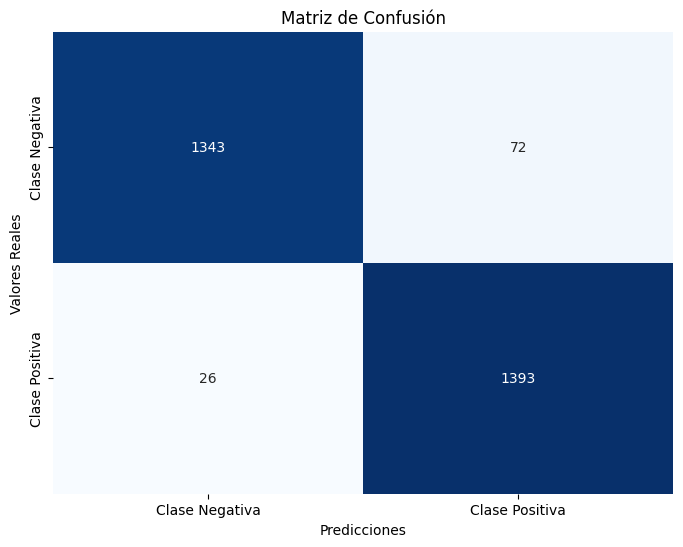

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

### ▶ M4 Fine-Tuning last-3-layers with Deberta

Este modelo es similar al modelo [M2] excepto por el modelo preentrenado que se utiliza: Deberta-base

- Se realiza un Fine-Tuning excepto de las ultimas 3 capas de Deberta-base


#### Preprocessing

In [ ]:
df_humans_train, df_humans_test = train_test_split(df_humans, test_size=0.2, random_state=42)
df_humans_train, df_humans_val = train_test_split(df_humans_train, test_size=0.1, random_state=42)

# Se filtran los dataFrames de máquinas según los índices de los subconjuntos de humanos
df_machines_list_train = [df_machine.loc[df_humans_train.index] for df_machine in df_machines_list]
df_machines_list_val = [df_machine.loc[df_humans_val.index] for df_machine in df_machines_list]
df_machines_list_test = [df_machine.loc[df_humans_test.index] for df_machine in df_machines_list]

train_df = generate_pairs(df_humans_train, df_machines_list_train)
val_df = generate_pairs(df_humans_val, df_machines_list_val)
test_df = generate_pairs(df_humans_test, df_machines_list_test)

print(f"Training samples: {train_df.shape}")
print(f"Validation samples: {val_df.shape}")
print(f"Testing samples: {test_df.shape}")

X_train = train_df.reset_index(drop=True)
X_val = val_df.reset_index(drop=True)
X_test = test_df.reset_index(drop=True)

### CustomDataset completo
train_dataset = CustomDataset_completo(X_train, tokenizerDeberta)
val_dataset = CustomDataset_completo(X_val, tokenizerDeberta)
test_dataset = CustomDataset_completo(X_test, tokenizerDeberta)

train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 2}
val_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}

print("TRAIN Dataset: {}".format(X_train.shape))
print("VAL Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **val_params)
testing_loader = DataLoader(test_dataset, **test_params)

Training samples: (10166, 3)
Validation samples: (1131, 3)
Testing samples: (2834, 3)
TRAIN Dataset: (10166, 3)
VAL Dataset: (1131, 3)
TEST Dataset: (2834, 3)


#### Model

In [ ]:
modelDeberta = AutoModel.from_pretrained("microsoft/deberta-base")

N = 3  # Número de capas finales que NO queremos congelar
for name, param in modelDeberta.named_parameters():
    if "encoder.layer" in name:               # Si el parámetro es parte del encoder
        layer_num = int(name.split(".")[2])   # Extrae el número de la capa
        if layer_num < (12 - N):              # Congela todas las capas excepto las últimas N
            param.requires_grad = False
    elif "classifier" in name:                # Deja sin congelar la capa de clasificación
        param.requires_grad = True

for name, param in modelDeberta.named_parameters():
  print(f"Capa: {name} | Congelada: {not param.requires_grad}")

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Capa: embeddings.word_embeddings.weight | Congelada: False
Capa: embeddings.LayerNorm.weight | Congelada: False
Capa: embeddings.LayerNorm.bias | Congelada: False
Capa: encoder.layer.0.attention.self.q_bias | Congelada: True
Capa: encoder.layer.0.attention.self.v_bias | Congelada: True
Capa: encoder.layer.0.attention.self.in_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_q_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_q_proj.bias | Congelada: True
Capa: encoder.layer.0.attention.output.dense.weight | Congelada: True
Capa: encoder.layer.0.attention.output.dense.bias | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.weight | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.bias | Congelada: True
Capa: encoder.layer.0.intermediate.dense.weight | Congelada: True
Capa: encoder.layer.0.intermediate.dense.bias | Congelada: True
Capa: encoder.

In [ ]:
class DebertaConcatenateClassifier_freezing(torch.nn.Module):
    def __init__(self, modelDeberta):
        super(DebertaConcatenateClassifier_freezing, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = modelDeberta
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 2)
        self.classifier = torch.nn.Linear(self.hidden_embd * 2, self.output_layer)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):

        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        combined_output = torch.cat((output_0, output_1), dim=1)

        combined_output = self.dropout(combined_output)
        output = self.classifier(combined_output)

        return output

In [ ]:
model = DebertaConcatenateClassifier_freezing(modelDeberta)
model.to(device)

DebertaConcatenateClassifier_freezing(
  (l1): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

#### Training process

In [ ]:
# Se define la funcion pérdida
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.optim as optim
import time

# Método de entrenamiento
def train(model, training_loader, validation_loader, EPOCHS = 2):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):

      print(f"epoch[{epoch}]")

      model.train()

      start_epoch_time = time.time()  # Hora de inicio de la época
      batch_time_accum = 0

      for i, data in enumerate(training_loader, 0):

          # Sincroniza antes de comenzar el batch
          if torch.cuda.is_available():
                torch.cuda.synchronize()

          start_batch_time = time.time()  # Hora de inicio del batch

          ids_0 = data['ids_0'].to(device, dtype=torch.long)
          mask_0 = data['mask_0'].to(device, dtype=torch.long)
          token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

          ids_1 = data['ids_1'].to(device, dtype=torch.long)
          mask_1 = data['mask_1'].to(device, dtype=torch.long)
          token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

          targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)

          optimizer.zero_grad()

          outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

          loss = loss_fn(outputs, targets)

          loss.backward()

          optimizer.step()

          if torch.cuda.is_available():
                torch.cuda.synchronize()

          end_batch_time = time.time()
          batch_duration = end_batch_time - start_batch_time
          batch_time_accum += batch_duration


          if i % 100 == 0:  # Cada 100 batches
              print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}, 'f'Time for last 100 batches: {batch_time_accum:.2f} sec')
              batch_time_accum = 0

      ### Validacion
      val_loss = evaluate(model, validation_loader)

      print(f'Validation Loss after Epoch {epoch}: {val_loss:.4f}')

      # Se guarda el modelo si la pérdida de validación ha mejorado
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f'Saving model with improved validation loss: {val_loss:.4f}')
          torch.save(model.state_dict(), '/content/debertaConcatenateClassifier_Freezing_corresp_noRepe.pth')

      end_epoch_time = time.time()
      epoch_duration = end_epoch_time - start_epoch_time
      print(f'Epoch {epoch} completed in {epoch_duration:.2f} sec')


def evaluate(model, validation_loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    start_eval_time = time.time()  # Hora de inicio de la evaluación

    with torch.no_grad():
        for data in validation_loader:

            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)


            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)


            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * len(targets)  # la pérdida ponderada por el tamaño del batch
            total_samples += len(targets)

    average_loss = total_loss / total_samples  # Promedio de la pérdida


    end_eval_time = time.time()
    eval_duration = end_eval_time - start_eval_time
    print(f'Evaluation completed in {eval_duration:.2f} sec')

    return average_loss

In [ ]:
train(model, training_loader, val_loader, 2)

epoch[0]
Epoch: 0, Batch: 0, Loss: 0.7687, Time for last 100 batches: 2.19 sec
Epoch: 0, Batch: 100, Loss: 0.0032, Time for last 100 batches: 43.47 sec
Epoch: 0, Batch: 200, Loss: 0.0018, Time for last 100 batches: 42.63 sec
Epoch: 0, Batch: 300, Loss: 0.0010, Time for last 100 batches: 45.65 sec
Epoch: 0, Batch: 400, Loss: 0.0003, Time for last 100 batches: 46.88 sec
Epoch: 0, Batch: 500, Loss: 0.0001, Time for last 100 batches: 46.97 sec
Epoch: 0, Batch: 600, Loss: 0.0018, Time for last 100 batches: 47.07 sec
Epoch: 0, Batch: 700, Loss: 0.0002, Time for last 100 batches: 47.84 sec
Epoch: 0, Batch: 800, Loss: 0.0000, Time for last 100 batches: 48.14 sec
Epoch: 0, Batch: 900, Loss: 0.0002, Time for last 100 batches: 47.33 sec
Epoch: 0, Batch: 1000, Loss: 0.0000, Time for last 100 batches: 49.26 sec
Evaluation completed in 25.80 sec
Validation Loss after Epoch 0: 0.0177
Saving model with improved validation loss: 0.0177
Epoch 0 completed in 512.48 sec
epoch[1]
Epoch: 1, Batch: 0, Loss: 

<a id='section06'></a>
#### Validating the Model


**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("/content/debertaConcatenateClassifier_Freezing_corresp_noRepe.pth"))

<ipython-input-20-b38dd9521caa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/debertaConcatenateClassifier_Freezing_corresp_noR

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
# Umbral
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"C@1 Score = {c1_score}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.9865913902611151
ROC_AUC Score = 0.999570682922942
F1 Score = 0.9867963863794301
F0.5 Score = 0.9806629834254144
C@1 Score = 0.9865913902611151
Brier Score = 0.9905414267052242


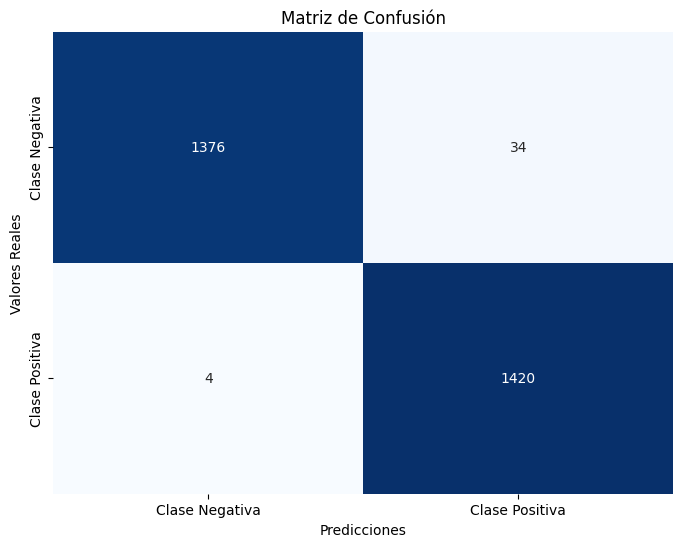

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

### ▶ M5 Similarity test with Deberta. Fine-Tuning last-3-layers

Se congelan la mayoria de capas de Deberta. Se parte del modelo [M4] pero con la adicción del calculo de similitud entre el embedding de la frase humana y la maquina.



#### Preprocessing

In [ ]:
df_humans_train, df_humans_test = train_test_split(df_humans, test_size=0.2, random_state=42)
df_humans_train, df_humans_val = train_test_split(df_humans_train, test_size=0.1, random_state=42)

# Se filtran los dataFrames de máquinas según los índices de los subconjuntos de humanos
df_machines_list_train = [df_machine.loc[df_humans_train.index] for df_machine in df_machines_list]
df_machines_list_val = [df_machine.loc[df_humans_val.index] for df_machine in df_machines_list]
df_machines_list_test = [df_machine.loc[df_humans_test.index] for df_machine in df_machines_list]

train_df = generate_pairs(df_humans_train, df_machines_list_train)
val_df = generate_pairs(df_humans_val, df_machines_list_val)
test_df = generate_pairs(df_humans_test, df_machines_list_test)

print(f"Training samples: {train_df.shape}")
print(f"Validation samples: {val_df.shape}")
print(f"Testing samples: {test_df.shape}")

X_train = train_df.reset_index(drop=True)
X_val = val_df.reset_index(drop=True)
X_test = test_df.reset_index(drop=True)

### CustomDataset completo
train_dataset = CustomDataset_completo(X_train, tokenizerDeberta)
val_dataset = CustomDataset_completo(X_val, tokenizerDeberta)
test_dataset = CustomDataset_completo(X_test, tokenizerDeberta)

train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 2}
val_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 2}

print("TRAIN Dataset: {}".format(X_train.shape))
print("VAL Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **val_params)
testing_loader = DataLoader(test_dataset, **test_params)

Training samples: (10166, 3)
Validation samples: (1131, 3)
Testing samples: (2834, 3)
TRAIN Dataset: (10166, 3)
VAL Dataset: (1131, 3)
TEST Dataset: (2834, 3)


#### Model

In [ ]:
modelDeberta = AutoModel.from_pretrained("microsoft/deberta-base")

N = 3  # Número de capas finales que NO queremos congelar
for name, param in modelDeberta.named_parameters():
    if "encoder.layer" in name:               # Si el parámetro es parte del encoder
        layer_num = int(name.split(".")[2])   # Extrae el número de la capa
        if layer_num < (12 - N):              # Congela todas las capas excepto las últimas N
            param.requires_grad = False
    elif "classifier" in name:                # Deja sin congelar la capa de clasificación
        param.requires_grad = True

for name, param in modelDeberta.named_parameters():
  print(f"Capa: {name} | Congelada: {not param.requires_grad}")

Capa: embeddings.word_embeddings.weight | Congelada: False
Capa: embeddings.LayerNorm.weight | Congelada: False
Capa: embeddings.LayerNorm.bias | Congelada: False
Capa: encoder.layer.0.attention.self.q_bias | Congelada: True
Capa: encoder.layer.0.attention.self.v_bias | Congelada: True
Capa: encoder.layer.0.attention.self.in_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_q_proj.weight | Congelada: True
Capa: encoder.layer.0.attention.self.pos_q_proj.bias | Congelada: True
Capa: encoder.layer.0.attention.output.dense.weight | Congelada: True
Capa: encoder.layer.0.attention.output.dense.bias | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.weight | Congelada: True
Capa: encoder.layer.0.attention.output.LayerNorm.bias | Congelada: True
Capa: encoder.layer.0.intermediate.dense.weight | Congelada: True
Capa: encoder.layer.0.intermediate.dense.bias | Congelada: True
Capa: encoder.

In [ ]:
class DebertaConcatenateSimilarityClassifier_freezing(torch.nn.Module):
    def __init__(self, modelDeberta):
        super(DebertaConcatenateSimilarityClassifier_freezing, self).__init__()

        self.dropout_rate = 0.3
        self.hidden_embd = 768
        self.output_layer = 1

        self.l1 = modelDeberta
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Capa lineal para la clasificación final (dado que concatenamos, multiplicamos el tamaño por 3)
        self.classifier = torch.nn.Linear(512, self.output_layer)
        # Nuevo conjunto de capas Linear, Relu y Dropout
        self.compare_layer = torch.nn.Sequential(
            torch.nn.Linear(768 * 3, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.dropout_rate)
        )

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):

        output_0 = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        output_1 = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        # Se concatenan los embeddings junto con la diferencia absoluta de ambos
        combined_output = torch.cat([output_0, output_1, torch.abs(output_0 - output_1)], dim=1)
        x = self.compare_layer(combined_output)

        # luego la capa lineal para hacer la predicción
        output = self.classifier(x)

        return output

In [ ]:
model = DebertaConcatenateSimilarityClassifier_freezing(modelDeberta)
model.to(device)

DebertaConcatenateSimilarityClassifier_freezing(
  (l1): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
 

#### Training process

In [ ]:
# Se define la funcion pérdida
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.optim as optim
import time

# Método de entrenamiento
def train(model, training_loader, validation_loader, EPOCHS = 2):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):

      print(f"epoch[{epoch}]")

      model.train()

      start_epoch_time = time.time()  # Hora de inicio de la época
      batch_time_accum = 0

      for i, data in enumerate(training_loader, 0):

          # Sincroniza antes de comenzar el batch
          if torch.cuda.is_available():
                torch.cuda.synchronize()

          start_batch_time = time.time()  # Hora de inicio del batch

          ids_0 = data['ids_0'].to(device, dtype=torch.long)
          mask_0 = data['mask_0'].to(device, dtype=torch.long)
          token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

          ids_1 = data['ids_1'].to(device, dtype=torch.long)
          mask_1 = data['mask_1'].to(device, dtype=torch.long)
          token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

          targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)

          optimizer.zero_grad()

          outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

          loss = loss_fn(outputs, targets)

          loss.backward()

          optimizer.step()

          if torch.cuda.is_available():
                torch.cuda.synchronize()

          end_batch_time = time.time()
          batch_duration = end_batch_time - start_batch_time
          batch_time_accum += batch_duration


          if i % 100 == 0:  # Cada 100 batches
              print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}, 'f'Time for last 100 batches: {batch_time_accum:.2f} sec')
              batch_time_accum = 0

      ### Validacion
      val_loss = evaluate(model, validation_loader)

      print(f'Validation Loss after Epoch {epoch}: {val_loss:.4f}')

      # Se guarda el modelo si la pérdida de validación ha mejorado
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f'Saving model with improved validation loss: {val_loss:.4f}')
          torch.save(model.state_dict(), '/content/debertaConcatenateClassifier_Freezing_corresp_withSimilarity.pth')

      end_epoch_time = time.time()
      epoch_duration = end_epoch_time - start_epoch_time
      print(f'Epoch {epoch} completed in {epoch_duration:.2f} sec')


def evaluate(model, validation_loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    start_eval_time = time.time()  # Hora de inicio de la evaluación

    with torch.no_grad():
        for data in validation_loader:

            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float).unsqueeze(1)


            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)


            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * len(targets)  # la pérdida ponderada por el tamaño del batch
            total_samples += len(targets)

    average_loss = total_loss / total_samples  # Promedio de la pérdida


    end_eval_time = time.time()
    eval_duration = end_eval_time - start_eval_time
    print(f'Evaluation completed in {eval_duration:.2f} sec')

    return average_loss

In [ ]:
train(model, training_loader, val_loader, 2)

epoch[0]
Epoch: 0, Batch: 0, Loss: 0.6784, Time for last 100 batches: 3.05 sec
Epoch: 0, Batch: 100, Loss: 0.0113, Time for last 100 batches: 43.20 sec
Epoch: 0, Batch: 200, Loss: 0.1597, Time for last 100 batches: 45.99 sec
Epoch: 0, Batch: 300, Loss: 0.0010, Time for last 100 batches: 46.07 sec
Epoch: 0, Batch: 400, Loss: 0.0019, Time for last 100 batches: 47.88 sec
Epoch: 0, Batch: 500, Loss: 0.0087, Time for last 100 batches: 47.76 sec
Epoch: 0, Batch: 600, Loss: 0.0000, Time for last 100 batches: 47.75 sec
Epoch: 0, Batch: 700, Loss: 0.0000, Time for last 100 batches: 49.35 sec
Epoch: 0, Batch: 800, Loss: 0.0003, Time for last 100 batches: 51.01 sec
Epoch: 0, Batch: 900, Loss: 0.0000, Time for last 100 batches: 50.23 sec
Epoch: 0, Batch: 1000, Loss: 0.0000, Time for last 100 batches: 49.68 sec
Evaluation completed in 31.28 sec
Validation Loss after Epoch 0: 0.0018
Saving model with improved validation loss: 0.0018
Epoch 0 completed in 532.60 sec
epoch[1]
Epoch: 1, Batch: 0, Loss: 

<a id='section06'></a>
#### Validating the Model


**Métricas**:
- **ROC-AUC**: mide el area bajo la curva ROC en una grafica; mide la relacion entre los verdaderos positivos y los falsos positivos a diferentes umbrales de precision. Por defecto, el umbral es de 0.5.
- **Brier Score**: mide la precisión de las predicciones de probabilidad, calculando el promedio de los errores cuadráticos entre las predicciones de probabilidad y las etiquetas reales.
- **C@1**: modifica la precisión (accuracy) tradicional asignando a los no-respuestas (o casos ambiguos) un valor de 0.5. Luego, calcula la precisión promedio para estos casos y los integra con el resto de predicciones.
- **F1-Score**: es la media armónica entre precisión y exhaustividad (recall)
- **F0.5u**: modifica el F0.5u, penliza menos la indecisión. La precisión es más importante que el recall.

In [ ]:
model.load_state_dict(torch.load("/content/debertaConcatenateClassifier_Freezing_corresp_withSimilarity.pth"))

<ipython-input-25-71f7b0ddee80>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/debertaConcatenateClassifier_Freezing_corresp_wit

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score

# C@1 es una extension de la Precision. A parte de contar el numero de aciertos (TP + TN / Total), también incorpora el número de no respuestas.
# Las "no-respuestas" son cuantas veces el modelo se abstuvo de responder. Para aquellas predicciones ambiguas, el modelo no responde y asigna un 0.5 de error, por lo que no afecta a la precision.
# Esta metrica es util cuando una respuesta incorrecta es peor que una falta de respuesta.

def c_at_1(y_true, y_pred, non_answer_value=0.5):
    correct = sum([1 if y == p else 0 for y, p in zip(y_true, y_pred)])
    non_answers = sum([1 if p == non_answer_value else 0 for p in y_pred])
    total = len(y_true)
    return (correct + (non_answers * (correct / (total - non_answers)))) / total


def f_0_5_u(y_true, y_pred, beta=0.5, non_answer_value=0.5):
    y_pred_adj = [p if p != non_answer_value else 0 for p in y_pred]  # 0 para no-respuestas
    precision = precision_score(y_true, y_pred_adj)
    recall = recall_score(y_true, y_pred_adj)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

In [ ]:
def validation():
    model.eval()  # Configura el modelo en modo evaluación
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for _, data in enumerate(testing_loader, 0):
            # Extrae los datos del lote y muévelos a la GPU
            ids_0 = data['ids_0'].to(device, dtype=torch.long)
            mask_0 = data['mask_0'].to(device, dtype=torch.long)
            token_type_ids_0 = data['token_type_ids_0'].to(device, dtype=torch.long)

            ids_1 = data['ids_1'].to(device, dtype=torch.long)
            mask_1 = data['mask_1'].to(device, dtype=torch.long)
            token_type_ids_1 = data['token_type_ids_1'].to(device, dtype=torch.long)

            targets = data['target'].to(device, dtype=torch.float)

            # Realiza la predicción con el modelo
            outputs = model(ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1)

            # Aplica la función sigmoide para obtener probabilidades
            probabilities = torch.sigmoid(outputs)

            # Agrega los resultados y los targets a las listas finales
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(probabilities.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
# Umbral
outputs2 = np.array(outputs) >= 0.5

### Métricas
roc_auc = roc_auc_score(targets, outputs)
brier_score = 1 - brier_score_loss(targets, outputs)
f1_score = metrics.f1_score(targets, outputs2)
accuracy = metrics.accuracy_score(targets, outputs2)

c1_score = c_at_1(targets, outputs2)
f0_5u_score = f_0_5_u(targets, outputs2)

print(f"Accuracy Score = {accuracy}")
print(f"ROC_AUC Score = {roc_auc}")
print(f"F1 Score = {f1_score}")
print(f"F0.5 Score = {f0_5u_score}")
print(f"C@1 Score = {c1_score}")
print(f"Brier Score = {brier_score}")


Accuracy Score = 0.9851799576570219
ROC_AUC Score = 0.9996562649450024
F1 Score = 0.985273492286115
F0.5 Score = 0.9911117381489843
C@1 Score = 0.9851799576570219
Brier Score = 0.990958676731155


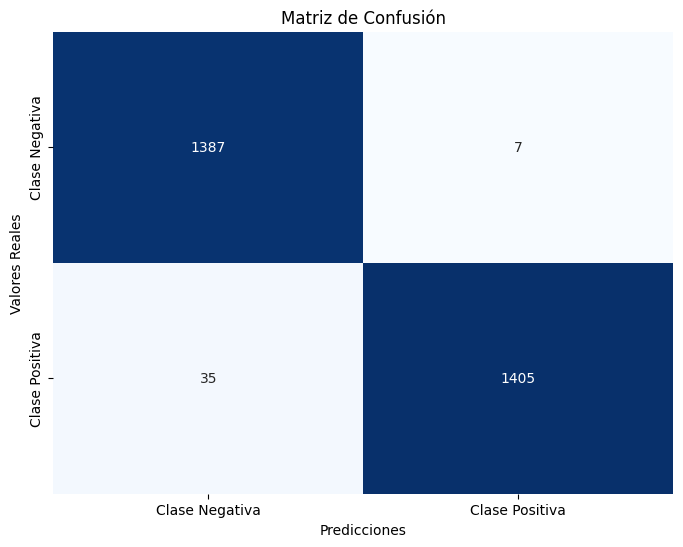

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(targets, outputs2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase Negativa", "Clase Positiva"], yticklabels=["Clase Negativa", "Clase Positiva"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()